<a href="https://colab.research.google.com/github/abdumhmd/kvasir-segmentation/blob/main/Segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!unzip /content/drive/MyDrive/kvasir-seg.zip

In [2]:
import os

!mkdir /content/Kvasir-SEG/images/img
!mv /content/Kvasir-SEG/images/*.jpg /content/Kvasir-SEG/images/img
!mkdir /content/Kvasir-SEG/masks/img
!mv /content/Kvasir-SEG/masks/*.jpg /content/Kvasir-SEG/masks/img
images=os.listdir('/content/Kvasir-SEG/images/img')
masks=os.listdir('/content/Kvasir-SEG/masks/img')

print(len(images))
print(len(masks))

1000
1000


(528, 600, 3)

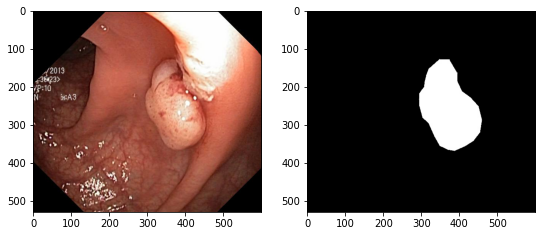

In [3]:
import matplotlib.pyplot as plt
from random import choice

sample=choice(os.listdir('/content/Kvasir-SEG/images/img/'))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 9)

img=plt.imread("/content/Kvasir-SEG/images/img/"+sample)
msk=plt.imread("/content/Kvasir-SEG/masks/img/"+sample)
axs[0].imshow(img)
axs[1].imshow(msk)

msk.shape


In [10]:
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


base_dir="/content/Kvasir-SEG"
size=(256,256)

def create_data():
    images_ = []
    masks_ =  []
    for i in tqdm(os.listdir(base_dir+"/images")):



        img_name = base_dir+"/images/"+ i 
        img_mask = base_dir+ "/masks/"+i 



        img = load_img(img_name, target_size=size)
        img = img_to_array(img)

        mask = load_img(img_mask, target_size=size)
        mask = img_to_array(mask)
        images_.append(img)
        masks_.append(mask)

    images_ =  np.array(images_)
    masks_ = np.array(masks_)
    print(images_.shape, masks_.shape)
    return images_,masks_

def train_val(x_train,y_train,ratio):
    X_train,X_val,y_train,y_valid=train_test_split(x_train,y_train,test_size=ratio)
    return  X_train,X_val,y_train,y_valid

In [5]:
from tensorflow.keras import backend as keras
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)



In [6]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
import numpy as np


images_ = []
masks_ =  []
size=(256,256)
for i in tqdm(os.listdir('/content/Kvasir-SEG/images/img/')):
    
    

    img_name = "/content/Kvasir-SEG/images/img/"+ i 
    img_mask = "/content/Kvasir-SEG/masks/img/" + i 
    
    
    
    img = load_img(img_name, target_size=size)
    img = img_to_array(img)
    
    mask = load_img(img_mask, target_size=size)
    mask = img_to_array(mask)
    images_.append(img)
    masks_.append(mask)
    
images_ =  np.array(images_)
masks_ = np.array(masks_)
print(images_.shape, masks_.shape)
filename = 'maps_256.npz'

100%|██████████| 1000/1000 [00:10<00:00, 99.43it/s]


(1000, 256, 256, 3) (1000, 256, 256, 3)


In [7]:
from numpy import load

#filename = 'maps_256.npz'
# Load training and testing data
#datatrain = load(filename)
X_train, y_train = images_, masks_

assert X_train.shape == y_train.shape
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(3, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    out = Activation('sigmoid')(x)
    
    
    model = Model(inputs=img_input, outputs=out)
    
    model.compile(optimizer= SGD(lr=0.00001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[IoU, dice_coef, 'AUC'])
    model.summary()
    hist = model.fit(X_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (X_valid, y_valid), verbose=1)
    
    model.save(savename)
    return model,hist

In [15]:
model, hist = segnet(100, 'segnet_1_epoch.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_104 (Activation)  (None, 256, 256, 64)     0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_105 (Activation)  (None, 256, 256, 64)     0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 deconv6 (Conv2DTranspose)   (None, 32, 32, 256)       1179904   
                                                                 
 bn19 (BatchNormalization)   (None, 32, 32, 256)       1024      
                                                                 
 activation_122 (Activation)  (None, 32, 32, 256)      0         
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 64, 64, 256)      0         
 g2D)                                                            
                                                                 
 deconv7 (Conv2DTranspose)   (None, 64, 64, 256)       590080    
                                                                 
 bn20 (BatchNormalization)   (None, 64, 64, 256)       1024      
                                                                 
 activation_123 (Activation)  (None, 64, 64, 256)      0         
                                                                 
 deconv8 (

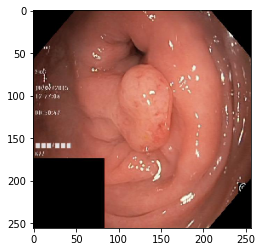

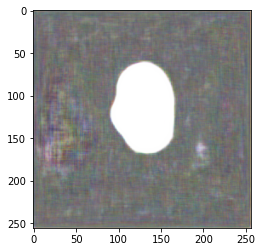

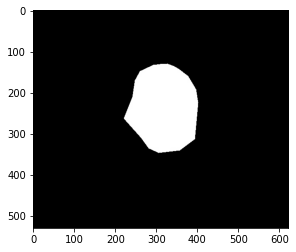

In [22]:
import matplotlib.pyplot as plt
from random import choice
sample =(choice(os.listdir('/content/Kvasir-SEG/images/img/')))

img = load_img('/content/Kvasir-SEG/images/img/'+sample, target_size=(256,256))
plt.imshow(img)
plt.show()

img = img_to_array(img)

img=np.expand_dims(img, axis=0)
images = np.vstack([img])
  



pred=model.predict(images)
plt.imshow(pred[0])
plt.show()

msk=plt.imread('/content/Kvasir-SEG/masks/img/'+sample)
plt.imshow(msk)